In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [4]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')
mdbMC = morph_db.query('n_f < 3 and zgrism <= 2 and lmass >= 10.5')
mdbMC2 = morph_db.query('n_f < 3 and lmass >= 11.0')
mdbG = morph_db.query('n_f < 2 and lmass >= 10.5')


In [38]:
field = 'GSD'
galaxies =41520

grow = morph_db.query('id == {0}'.format(galaxies))

Gs = Gen_spec(field, galaxies, grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
Flam = Posterior_spec(field, galaxies)

x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field, galaxies))
bp1 = x[px == max(px)][0]
x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field, galaxies))
rp1 = x[px == max(px)][0]

Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


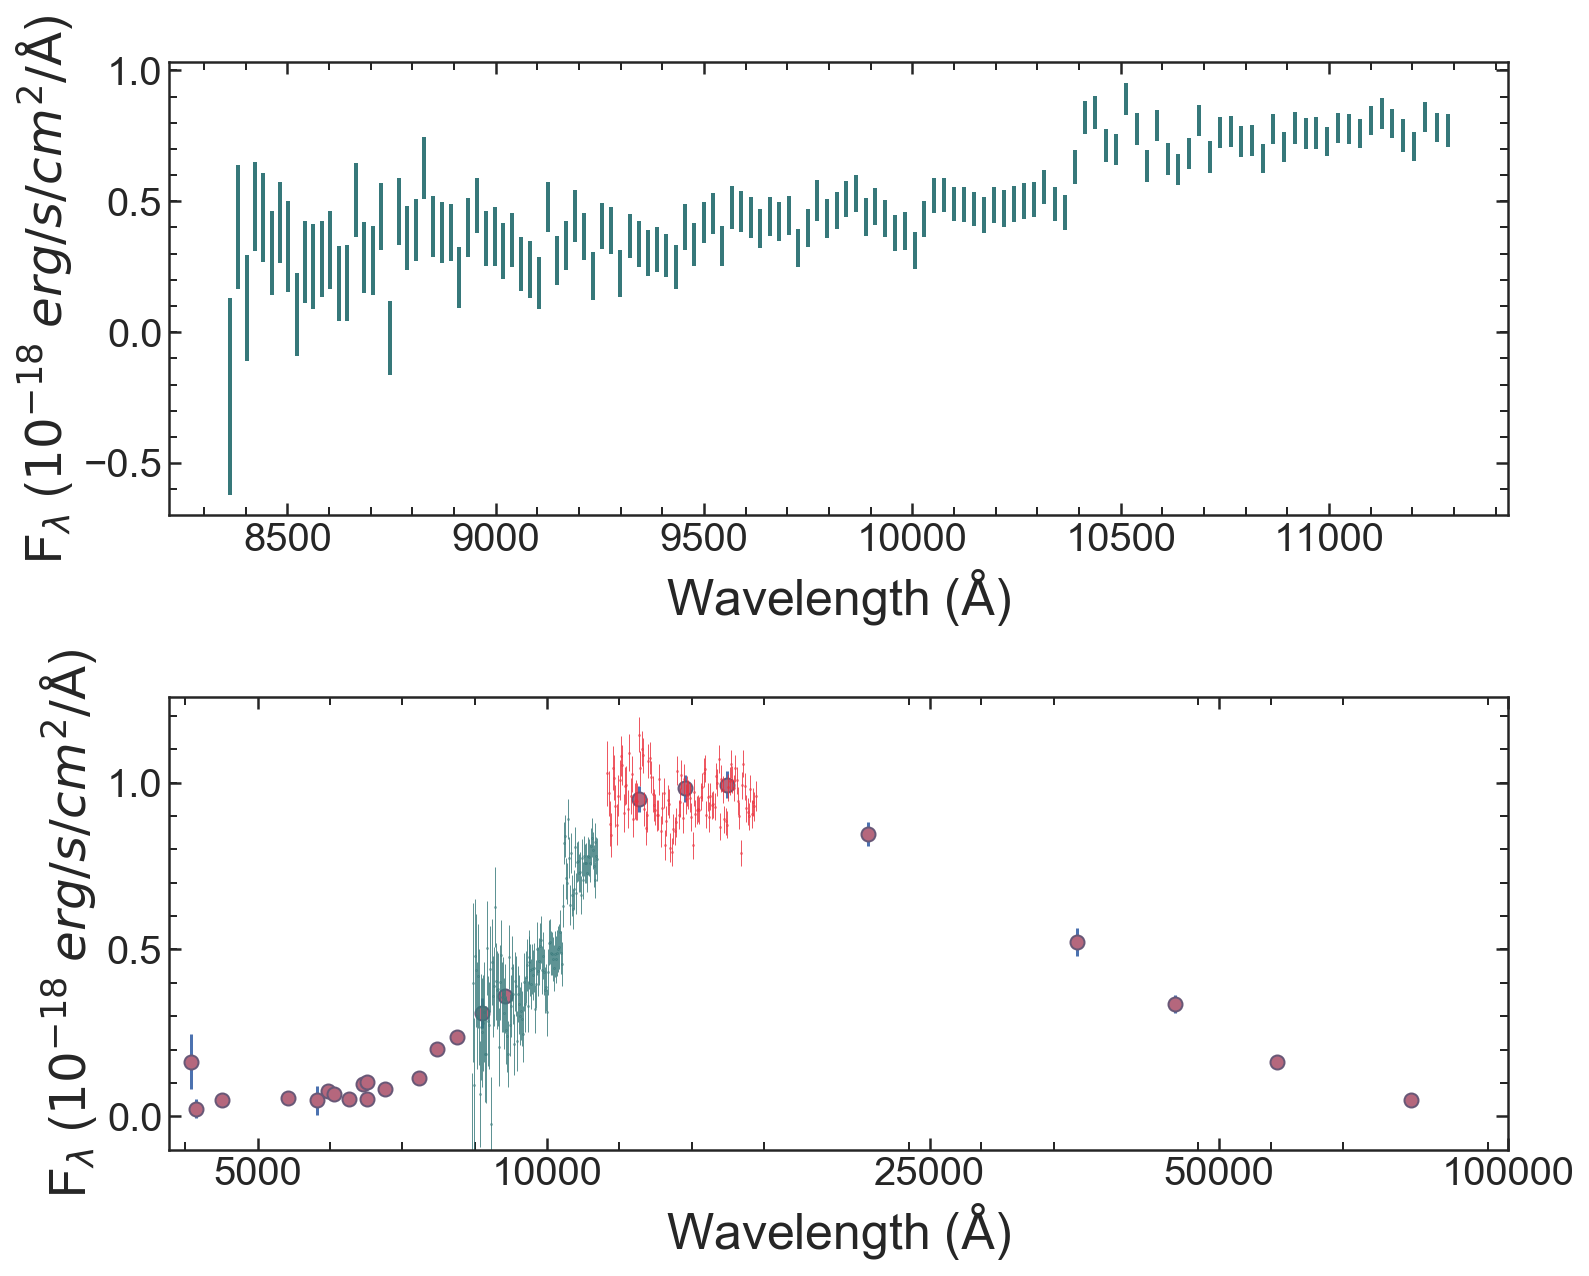

In [39]:
gs = gridspec.GridSpec(2,1, hspace=0.4)

plt.figure(figsize= [12,10])
##############plot tab##################
plt.subplot(gs[0])
plt.errorbar(Gs.Bwv,Gs.Bfl *1E18,Gs.Ber *1E18,
        linestyle='None', marker='o', markersize=0.5, color='#36787A', zorder = 2, elinewidth = 2)

plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()

plt.subplot(gs[1])
plt.errorbar(np.log10(Gs.Bwv),Gs.Bfl *1E18,Gs.Ber *1E18,
        linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)

plt.errorbar(np.log10(Gs.Rwv),Gs.Rfl *1E18,Gs.Rer *1E18,
        linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)

plt.errorbar(np.log10(Gs.Pwv),Gs.Pflx*1E18,Gs.Perr*1E18,
        linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
             markeredgecolor = '#685877',markeredgewidth = 1)

plt.xlim(np.log10(min(Gs.Pwv)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
plt.ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

plt.xticks(np.log10([5000,10000,25000, 50000, 100000]),np.array([5000,10000,25000, 50000, 100000]))
plt.xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
plt.ylabel(r'F$_\lambda$ ($10^{-18}$ $erg/s/cm^{2}/ \rm \AA $)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.minorticks_on()
plt.savefig('../plots/presentation_plots/41520_2spec.png', bbox_inches = 'tight')

In [40]:
sfh = Rescale_sfh('GSD',41520)

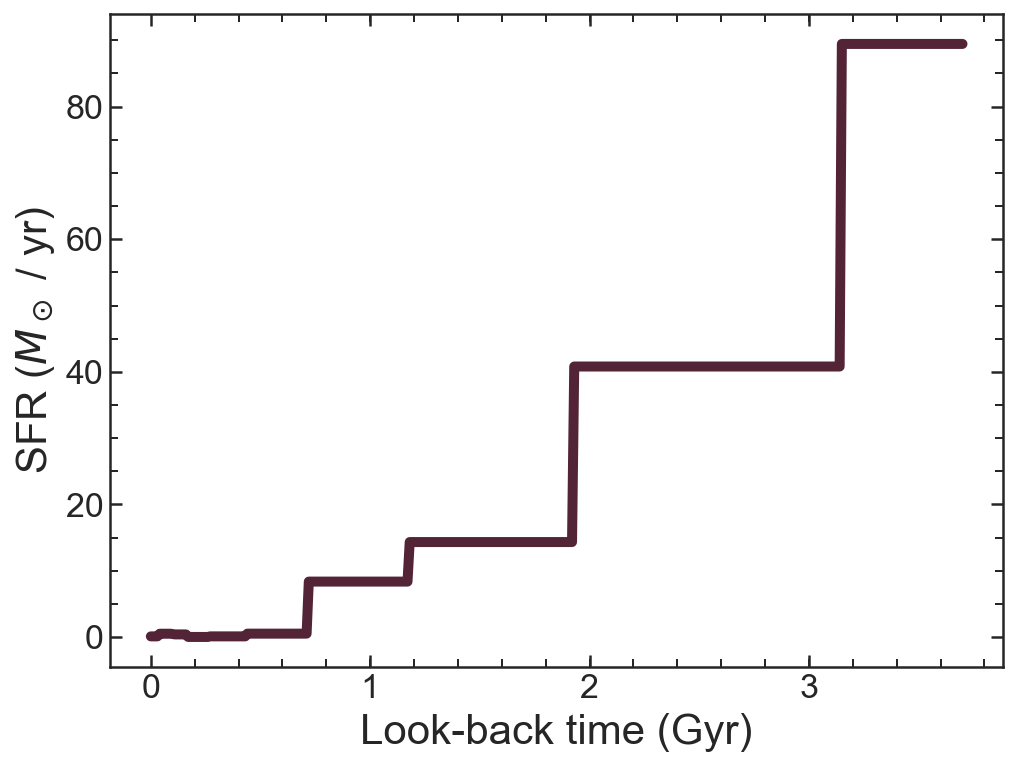

In [48]:
plt.figure(figsize= [8,6])

plt.plot(sfh.fulltimes, sfh.sfr_grid[0], color = '#532436', linewidth = 5)
plt.xlabel('Look-back time (Gyr)', fontsize=21)
plt.ylabel('SFR ($M_\odot$ / yr)', fontsize=21)   
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
plt.savefig('../plots/presentation_plots/sfh_example.png', bbox_inches = 'tight')

In [49]:

def Z_prior_mu(lmass):
    M = [9, 11.5]
    P = [-0.5813, 0.06818]
    iP = interp1d(M,P)
    return iP(lmass) 

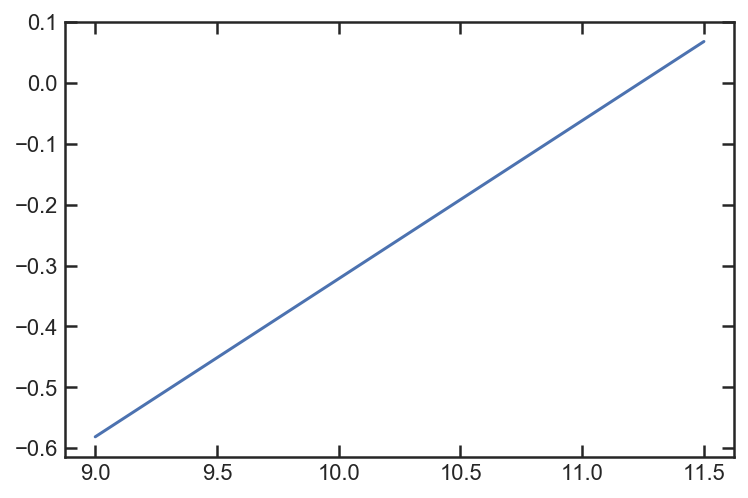

In [51]:
plt.plot(np.linspace(9.0,11.5), Z_prior_mu(np.linspace(9.0,11.5)))